# 상황
- The next development cycle의 일부로 yammer site의 search functionality를 향상시키고자 함.
- 프로덕트 팀이 우선순위를 정해야 하는데... 개발 사이클에서 어떤 것들을 우선순위를 가지고 개발해야 될지?
  - 가장 먼저 search box 개선을 하려한다.

## yammer의 search box 설명
- web site의 header에 search box가 있고, 이를 이용해서 people, groups, and conversations를 찾아볼 수 있음.
- User가 search box에 무언가를 타이핑했을 때 가장 연관있는 결과가 dropdown list형식으로 보여짐. 이는 카테고리 별로 나뉘어서 보이지는데, 카테고리는 people, conversations, files 등이 있다. Dropdown list의 맨 아래에는  'See All Search Results'라는 옵션이 있다.
- 'See All Search Results'를 클릭하면 results 페이지로 이동하게 되는데, results 페이지에는 카테고리별로 tab이 있다. (people, conversations, groups, files...)
- Results 페이지에는 'advanced search'라는 기능이 있다. (box 형태로). 특정한 yammer group이나 날짜를 상세하여 검색할 수 있다.

# The problem
- Before tackling search, the product team wants to make sure that the engineering team's time will be well-spent in doing so. After all, each new feature comes at the expense of some other potential feature(s). The product team is most interested in determining whether they should even work on search in the first place and, if so, how they should modify it.

# Getting oriented
- Before looking at the data, develop some hypotheses about `how users might interact with search`. 
  - What is the purpose of search? 
  - How would you know if it is fulfilling that purpose? 
  - How might you (`quantitatively`, 정량적으로) understand the general quality of an individual user's search experience?

- 검색기능을 사용할 때 유저에게 `만족감`을 주고 있는지 알고싶다.

1. 검색기능이 제대로 작동하는지?
2. 검색의 질..서비스 질은 괜찮은지??


In [2]:
# 패키지
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
from mysql_connector import *

connection = create_mysql_connection('localhost','CLOUDY','1234','yammers')

Connected to MySQL server : localhost


In [5]:
query = " SELECT * FROM events "
df = pd.read_sql(query, connection)
df.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


In [6]:
query = " SELECT * FROM users "
user_df = pd.read_sql(query, connection)
user_df

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,None,pending
2,2.0,2013-01-01 10:59:05,51.0,english,None,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active
...,...,...,...,...,...,...
19061,19061.0,2014-08-31 13:21:16,2156.0,chinese,2014-08-31 13:22:50,active
19062,19062.0,2014-08-31 19:21:23,7520.0,spanish,None,pending
19063,19063.0,2014-08-31 07:10:41,72.0,spanish,2014-08-31 07:12:09,active
19064,19064.0,2014-08-31 17:45:18,2.0,english,None,pending


In [53]:
# 사용언어별 event의 수... 특정 국가에서 서치가 적다면.. 해당 언어의 서비스 질이 좋지 않다는건 아닐까?
query = " SELECT DATE_SUB(DATE_FORMAT(e.occurred_at, '%Y-%m-%d'), INTERVAL WEEKDAY(e.occurred_at) DAY) as start_weekday, \
            u.user_id, u.language, u.state, e.event_name \
            FROM users u \
                LEFT JOIN events e \
                    ON u.user_id = e.user_id \
                        WHERE event_name LIKE '%search%' \
                            AND event_type='engagement' \
                                 AND state = 'active' "

df = pd.read_sql(query, connection)
df

,start_weekday,user_id,language,state,event_name
0,2014-05-12,4.0,indian,active,search_autocomplete
1,2014-05-12,4.0,indian,active,search_autocomplete
2,2014-05-26,4.0,indian,active,search_autocomplete
3,2014-05-19,4.0,indian,active,search_run
4,2014-05-19,4.0,indian,active,search_autocomplete
...,...,...,...,...,...
40606,2014-08-25,18809.0,arabic,active,search_autocomplete
40607,2014-08-25,18809.0,arabic,active,search_autocomplete
40608,2014-08-25,18809.0,arabic,active,search_autocomplete
40609,2014-08-25,18809.0,arabic,active,search_autocomplete


In [54]:
df.drop_duplicates(inplace=True)
df.shape

(17358, 5)

In [55]:
df

,start_weekday,user_id,language,state,event_name
0,2014-05-12,4.0,indian,active,search_autocomplete
2,2014-05-26,4.0,indian,active,search_autocomplete
3,2014-05-19,4.0,indian,active,search_run
4,2014-05-19,4.0,indian,active,search_autocomplete
7,2014-05-26,4.0,indian,active,search_run
...,...,...,...,...,...
40590,2014-08-25,18788.0,english,active,search_autocomplete
40594,2014-08-25,18795.0,english,active,search_autocomplete
40597,2014-08-25,18797.0,english,active,search_run
40599,2014-08-25,18797.0,english,active,search_autocomplete


In [56]:
group_df = df.groupby(['start_weekday','event_name']).count()[['user_id']]
group_df.reset_index(inplace=True)

In [57]:
pivot_group_df = group_df.pivot(index='start_weekday',columns='event_name',values='user_id')

In [58]:
pivot_group_df = pivot_group_df[['search_autocomplete', 'search_click_result_1',
       'search_click_result_2',
       'search_click_result_3', 'search_click_result_4',
       'search_click_result_5', 'search_click_result_6',
       'search_click_result_7', 'search_click_result_8',
       'search_click_result_9','search_click_result_10',  'search_run']]

<AxesSubplot:xlabel='start_weekday'>

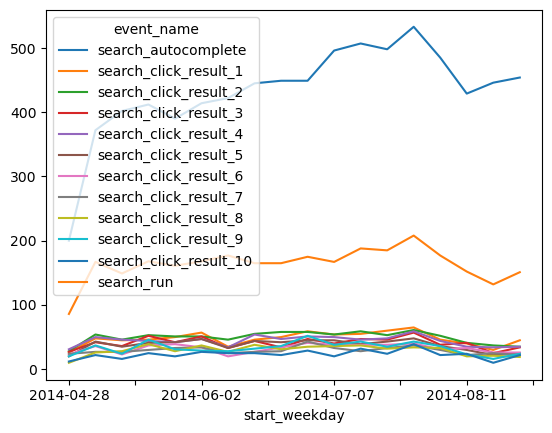

In [59]:
pivot_group_df.plot()

- search_qutocomplete기능에 문제가 있는 것 같은데?
- search run도...

In [60]:
df

,start_weekday,user_id,language,state,event_name
0,2014-05-12,4.0,indian,active,search_autocomplete
2,2014-05-26,4.0,indian,active,search_autocomplete
3,2014-05-19,4.0,indian,active,search_run
4,2014-05-19,4.0,indian,active,search_autocomplete
7,2014-05-26,4.0,indian,active,search_run
...,...,...,...,...,...
40590,2014-08-25,18788.0,english,active,search_autocomplete
40594,2014-08-25,18795.0,english,active,search_autocomplete
40597,2014-08-25,18797.0,english,active,search_run
40599,2014-08-25,18797.0,english,active,search_autocomplete


In [64]:
lan_df = df.groupby(['start_weekday','language']).count()[['user_id']]
lan_df

user_id
start_weekday language          
2014-04-28    arabic          16
              chinese         19
              english        241
              french          43
              german          15
...                          ...
2014-08-25    japanese        61
              korean          16
              portugese        9
              russian         29
              spanish         74

[216 rows x 1 columns]

In [66]:
lan_df.reset_index(inplace=True)
pivot_lan_df = lan_df.pivot(index ='start_weekday',columns='language',values='user_id')
pivot_lan_df

language,arabic,chinese,english,french,german,indian,italian,japanese,korean,portugese,russian,spanish
start_weekday,,,,,,,,,,,,
2014-04-28,16,19,241,43,15,15,8,31,3,18,19,79
2014-05-05,45,45,409,73,57,66,31,53,18,26,21,80
2014-05-12,26,42,451,59,33,20,24,74,11,29,36,72
2014-05-19,36,42,468,71,45,38,21,75,37,23,40,97
2014-05-26,29,34,432,66,63,46,19,50,11,46,42,91
2014-06-02,31,43,525,80,87,21,13,80,11,21,8,76
2014-06-09,35,30,479,64,56,16,18,69,18,16,29,75
2014-06-16,65,37,463,87,68,25,16,66,15,14,35,111
2014-06-23,31,57,503,69,72,38,18,65,10,22,30,81


<AxesSubplot:xlabel='start_weekday'>

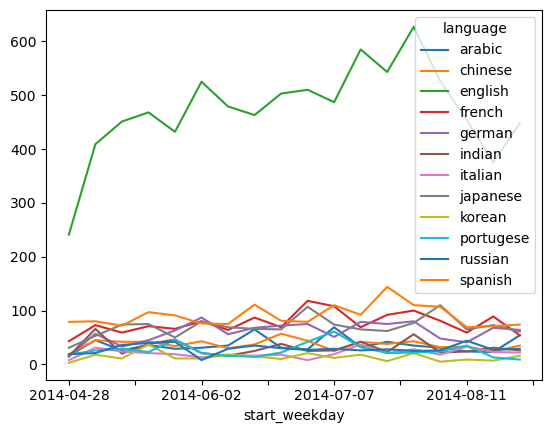

In [67]:
pivot_lan_df.plot()

In [69]:
pivot_lan_df2 = pivot_lan_df[['arabic', 'chinese', 'french', 'german', 'indian', 'italian',
       'japanese', 'korean', 'portugese', 'russian', 'spanish']]

<AxesSubplot:xlabel='start_weekday'>

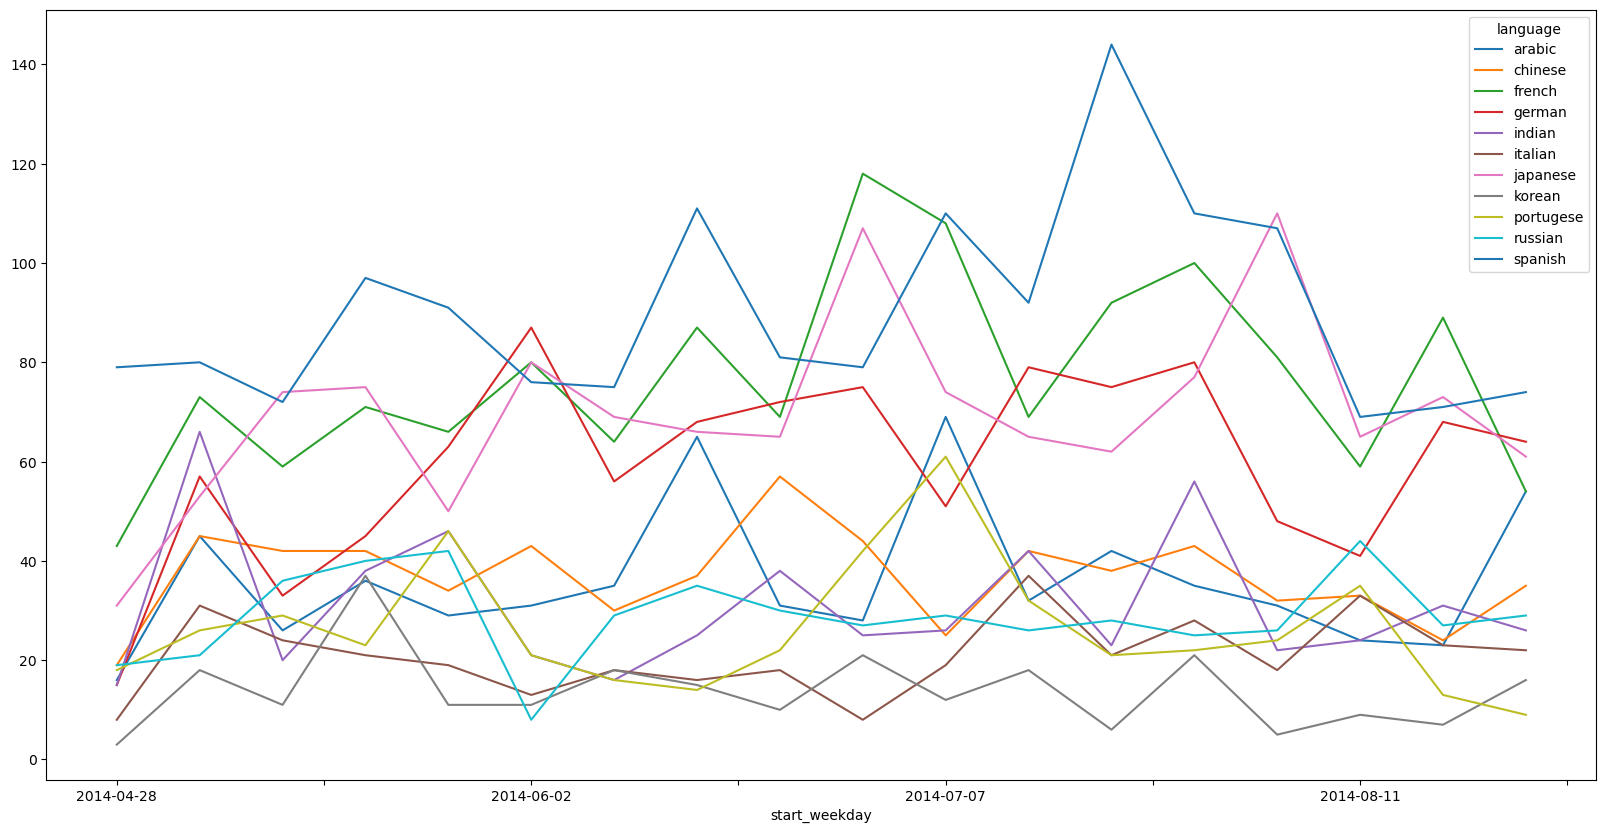

In [73]:
pivot_lan_df2.plot(figsize=(20,10))

- spanish, russian을 쓰는 user수가 급감